<a href="https://colab.research.google.com/github/amita-kapoor/AML-Classifiers/blob/master/ALL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset source : https://homes.di.unimi.it/scotti/all/

In [0]:
from google.colab import files
files.upload()

Saving ALL_Data2.zip to ALL_Data2.zip


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('ALL_Data2.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
!ls

ALL_Data2.zip  img  sample_data


Loading requires packages

In [0]:
from pathlib import Path
import glob
import cv2
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy import ndimage
from skimage import exposure
import skimage
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
#import tensornets as nets
import keras
from keras.utils import np_utils
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception,preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam,RMSprop,SGD
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from keras import backend as K
%matplotlib inline

In [0]:
images_dir = Path('img')
images = images_dir.glob("*.tif")

train_data = []

counter = 0
for img in images:
  counter += 1
  if counter <= 130:
    
    train_data.append((img,1))
    
  else:
    
    train_data.append((img,0))
 

  
  
train_data = pd.DataFrame(train_data,columns=['image','label'],index = None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.tail()


,image,label
255,img/Im074_1.tif,1
256,img/Im125_1.tif,1
257,img/Im197_0.tif,1
258,img/Im134_0.tif,0
259,img/Im258_0.tif,0


In [0]:
len(train_data)

260

Data Exploration and Augmentation

In [0]:
def data_gen(dataframe):
  n = len(dataframe)
  
  data = np.zeros((n*6,229,229,3),dtype = np.float32)
  labels = np.zeros((n*6,2),dtype = np.float32)
  
  
  count = 0
  
    
  for j in range(0,n):
    
    img_name = dataframe.iloc[j]['image']
    label = dataframe.iloc[j]['label']
      
    encoded_label = np_utils.to_categorical(label, num_classes=2)
            
    img = cv2.imread(str(img_name))
    img = cv2.resize(img, (229,229))
      
    if img.shape[2]==1:
     
      img = np.dstack([img, img, img])
                        
    #orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
    orig_img = img.astype(np.float32)/255.
                        
    data[count] = orig_img
    labels[count] = encoded_label
                        
      
      
    aug_img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #aug_img2 = skimage.exposure.equalize_adapthist(aug_img1, kernel_size = 8, clip_limit=0.01, nbins=256)
    aug_img2 = cv2.flip(img, 0) 
    aug_img3 = cv2.flip(img,1)
    aug_img4 = ndimage.gaussian_filter(img, sigma=5.11)
    aug_img5 = cv2.warpAffine(img, np.float32([[1, 0, 84], [0, 1, 56]]), (img.shape[1], img.shape[0]),borderMode=cv2.BORDER_CONSTANT, borderValue=(144, 159, 162))
      
    aug_img1 = np.dstack([aug_img1, aug_img1, aug_img1])
    #aug_img2 = np.dstack([aug_img2, aug_img2, aug_img2])
      
    aug_img1 = aug_img1.astype(np.float32)/255.
    #aug_img2 = aug_img2.astype(np.float32)/255.                  
    aug_img2 = aug_img2.astype(np.float32)/255.
    aug_img3 = aug_img3.astype(np.float32)/255. 
    aug_img4 = aug_img4.astype(np.float32)/255.
    aug_img5 = aug_img5.astype(np.float32)/255.
                        
    data[count+1] = aug_img1
    labels[count+1] = encoded_label
    data[count+2] = aug_img2
    labels[count+2] = encoded_label
    data[count+3] = aug_img3
    labels[count+3] = encoded_label
    data[count+4] = aug_img4
    labels[count+4] = encoded_label
    data[count+5] = aug_img5
    labels[count+5] = encoded_label
    #data[count+6] = aug_img6
    #labels[count+6] = encoded_label 
                        
    count +=6
    
                      
      
  return data,labels                  

In [0]:
data,labels = data_gen(train_data)


In [0]:
data.shape

(1560, 229, 229, 3)

In [0]:
labels.shape

(1560, 2)

In [0]:
data = np.asarray(data)
labels = np.asarray(labels)

Visualizing dataset images

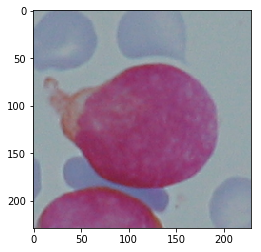

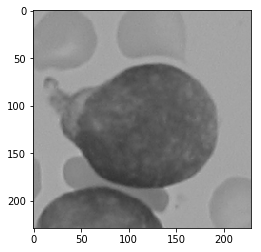

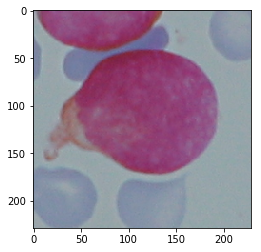

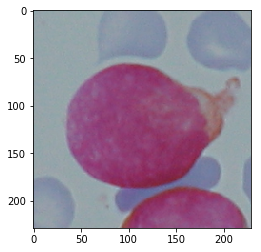

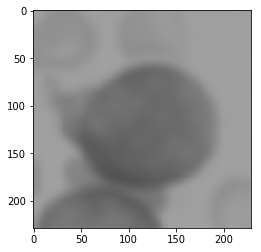

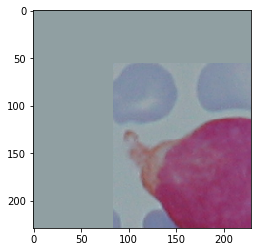

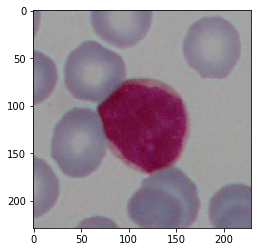

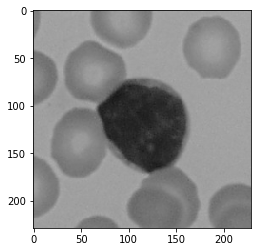

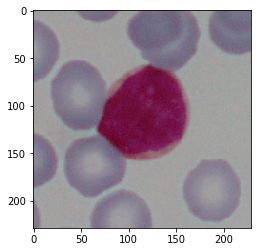

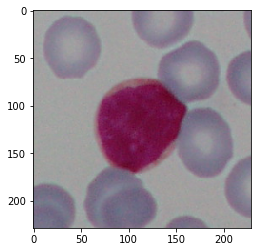

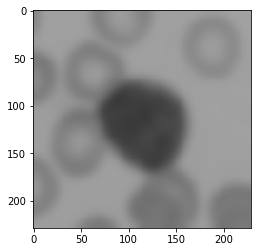

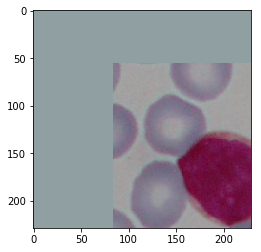

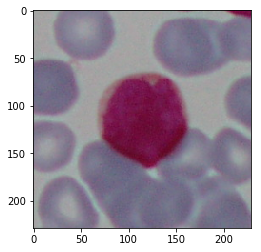

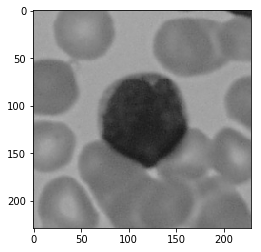

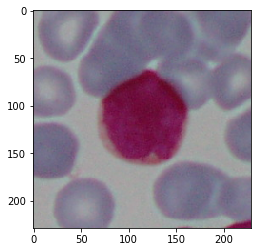

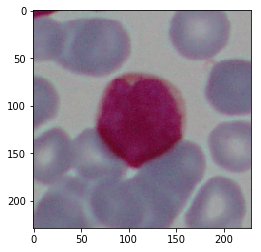

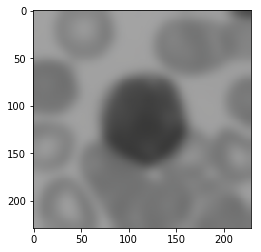

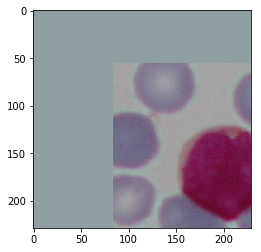

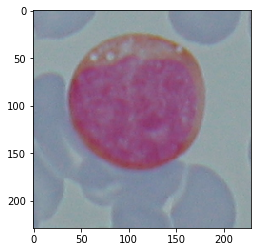

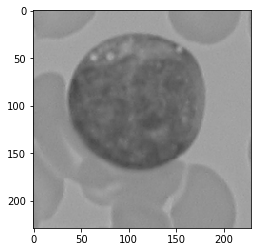

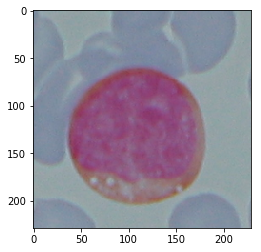

In [0]:
for i in range(0,21):
  plt.imshow(data[i])
  plt.show()

In [0]:
Data,Label = shuffle(data,labels, random_state=2)
data_list = [Data,Label]
type(data_list)

list

In [0]:
(X, y) = (data_list[0],data_list[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [0]:
data_generator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=15,zoom_range=0.1 )

Transfer Learning via Inception V3 , Xception and VGG16 pretrained models

Experimenting with Inception V3 first

In [0]:
#base_model = Xception(weights='imagenet',include_top = False,input_shape=(229,229,3))
base_model = InceptionV3(weights='imagenet',include_top=False,input_shape=(229,229,3))
#base_model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [0]:
len(base_model.layers)

311

In [0]:
# For using base model as a feature extractor only
base_model.trainable = False

In [0]:
# For fine tuning purpose

# base_model.trainable = True
# for layer in base_model.layers[:75]:
  #layer.trainable =  False

In [0]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 114, 114, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 114, 114, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Building our own classifier on top of base model according to our specific classification task

In [0]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
#model.add(Dense(1024,activation='relu'))
#model.add(Dropout(0.7))
#model.add(Dense(512,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102402    
Total params: 21,905,186
Trainable params: 102,402
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
optimizer = RMSprop(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

W0615 08:58:07.504001 140622307583872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0615 08:58:07.515189 140622307583872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

In [0]:
batch_size = 32
epochs = 4
history = model.fit_generator(data_generator.flow(X_train,y_train,batch_size = batch_size),steps_per_epoch = int(len(X_train)/batch_size),epochs=epochs)
history

Epoch 1/4
39/39 [==============================] - 18s 474ms/step - loss: 1.0627 - acc: 0.5048
Epoch 2/4
39/39 [==============================] - 12s 315ms/step - loss: 0.9567 - acc: 0.4992
Epoch 3/4
39/39 [==============================] - 12s 315ms/step - loss: 0.9178 - acc: 0.5353
Epoch 4/4
39/39 [==============================] - 12s 316ms/step - loss: 0.8227 - acc: 0.5689


In [0]:
score = model.evaluate(X_test,y_test,verbose=0)
score

[1.070976789181049, 0.4871794887078114]

The results get better when trained longer 

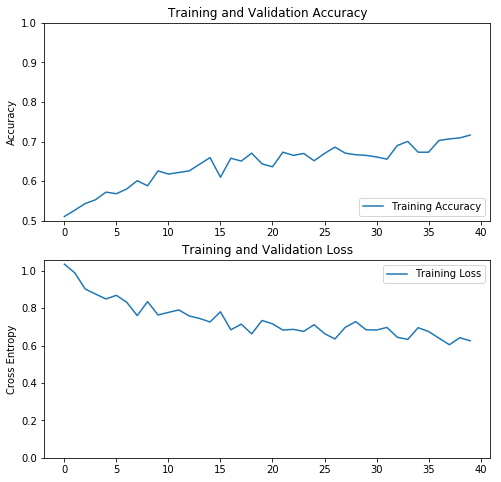

In [0]:
acc = history.history['acc']
#val_acc = history.history['val_acc']

loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

Trying Xception model

In [0]:
base_model = Xception(weights='imagenet',include_top = False,input_shape=(229,229,3))

83689472/83683744 [==============================] - 1s 0us/step


In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 114, 114, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 114, 114, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 114, 114, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [0]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
#model.add(Dense(1024,activation='relu'))
#model.add(Dropout(0.7))
#model.add(Dense(512,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 200706    
Total params: 21,062,186
Trainable params: 200,706
Non-trainable params: 20,861,480
_________________________________________________________________


In [0]:
optimizer = RMSprop(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [0]:
batch_size = 32
epochs = 40
history = model.fit_generator(data_generator.flow(X_train,y_train,batch_size = batch_size),steps_per_epoch = int(len(X_train)/batch_size),epochs=epochs)
history

Epoch 1/40
39/39 [==============================] - 16s 421ms/step - loss: 0.9114 - acc: 0.5232
Epoch 2/40
39/39 [==============================] - 13s 339ms/step - loss: 0.8013 - acc: 0.5769
Epoch 3/40
39/39 [==============================] - 13s 341ms/step - loss: 0.7762 - acc: 0.5817
Epoch 4/40
39/39 [==============================] - 13s 342ms/step - loss: 0.7805 - acc: 0.5905
Epoch 5/40
39/39 [==============================] - 13s 342ms/step - loss: 0.7267 - acc: 0.6266
Epoch 6/40
39/39 [==============================] - 13s 340ms/step - loss: 0.6827 - acc: 0.6659
Epoch 7/40
39/39 [==============================] - 13s 340ms/step - loss: 0.6926 - acc: 0.6554
Epoch 8/40
39/39 [==============================] - 13s 338ms/step - loss: 0.6939 - acc: 0.6530
Epoch 9/40
39/39 [==============================] - 13s 339ms/step - loss: 0.6512 - acc: 0.6923
Epoch 10/40
39/39 [==============================] - 13s 342ms/step - loss: 0.6380 - acc: 0.6771
Epoch 11/40
39/39 [====================

In [0]:
score = model.evaluate(X_test,y_test,verbose=0)
score

[1.4751736781536005, 0.4807692307692308]